In [2]:
import numpy as np
import pandas as pd

from typing import Tuple

def extract_time(df: pd.DataFrame) -> np.ndarray:
    t = df['t'].to_numpy() * 1e-9
    return t

def sync_timeseries(
    ref_time: np.ndarray,
    ref_data: np.ndarray,
    data_time: np.ndarray,
    data: np.ndarray,
    fix_time: bool,
    start_idx: int = 0,
    stop_idx: int = -1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    idx = np.searchsorted(ref_time, data_time, side="right") - 1

    valid = idx >= 0

    t_sync = data_time[valid]
    ref_sync = ref_data[idx[valid]]
    data_sync = data[valid]

    if fix_time:
        t_sync -= t_sync[0]

    t_sync = t_sync[start_idx:stop_idx]
    ref_sync = ref_sync[start_idx:stop_idx]
    data_sync = data_sync[start_idx:stop_idx]

    return t_sync, ref_sync, data_sync

In [3]:
from load_parquet import load_topic_dataframes

path = '../data/acc_three_levels_juggler2_rosbag.parquet'
topics_file = 'topics_lists/topics_acc.txt'

ms2kmh = 3.6

In [4]:
dataframes = load_topic_dataframes(path, topics_file)
dataframes.keys()

dict_keys(['carla__hero__vehicle_control_cmd__cc_control', 'carla__hero__vehicle_control_cmd__acc_control', 'carla__hero__vehicle_control_cmd', 'carla__dummy__vehicle_control_cmd', 'carla__hero__v_ref', 'carla__dummy__v_ref', 'carla__hero__y_vector', 'carla__dummy__y_vector', 'carla__hero__velocity', 'carla__dummy__velocity', 'carla__hero__imu', 'carla__dummy__imu', 'carla__hero__position', 'carla__dummy__position', 'carla__hero__dist_ref', 'carla__hero__dist'])

In [5]:
v_host = dataframes['carla__hero__velocity']
v_host.head(1)

,t,data
0,1766569376642024737,0.0


In [6]:
v_dummy = dataframes['carla__dummy__velocity']
v_dummy.head(1)

,t,data
0,1766569376646476536,0.0


In [7]:
dist_ref = dataframes['carla__hero__dist_ref']
dist_ref.head(1)

,t,data
0,1766569428492607236,27.098015


In [8]:
dist = dataframes['carla__hero__dist']
dist.head(1)

,t,data
0,1766569428492873226,162.927734


In [9]:
def zoh_sync(
    ref_time: np.ndarray,
    src_time: np.ndarray,
    src_data: np.ndarray,
) -> np.ndarray:
    """
    Zero-order hold sync:
    value at ref_time[i] = src_data[j], where j = max idx s.t. src_time[j] <= ref_time[i]
    """
    idx = np.searchsorted(src_time, ref_time, side="right") - 1
    idx[idx < 0] = 0
    idx[idx >= len(src_data)] = len(src_data) - 1
    return src_data[idx]

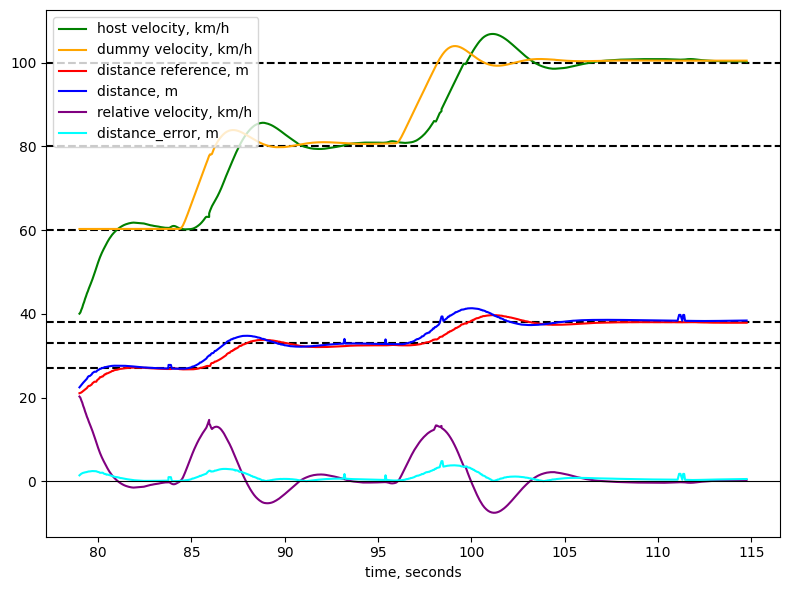

In [47]:
import matplotlib.pyplot as plt

# -------------------------------------------------
# common time origin
# -------------------------------------------------

t0 = extract_time(v_host)[0]

v_host_time = extract_time(v_host) - t0
v_dummy_time = extract_time(v_dummy) - t0
dist_ref_time = extract_time(dist_ref) - t0
dist_time = extract_time(dist) - t0

v_host_data = v_host["data"].to_numpy() * ms2kmh

# -------------------------------------------------
# ZOH sync
# -------------------------------------------------

v_dummy_sync = zoh_sync(
    v_host_time,
    v_dummy_time,
    v_dummy["data"].to_numpy() * ms2kmh,
)

dist_ref_sync = zoh_sync(
    v_host_time,
    dist_ref_time,
    dist_ref["data"].to_numpy(),
)

dist_sync = zoh_sync(
    v_host_time,
    dist_time,
    dist["data"].to_numpy(),
)

CUT_BEGIN = 79
CUT_END = 114.8

t_max = v_host_time[-1]
mask = (
    (v_host_time >= CUT_BEGIN) &
    (v_host_time <= CUT_END)
)

v_host_time = v_host_time[mask]
v_host_data = v_host_data[mask]
v_dummy_sync = v_dummy_sync[mask]
dist_ref_sync = dist_ref_sync[mask]
dist_sync = dist_sync[mask]

# -------------------------------------------------
# plot
# -------------------------------------------------

plt.figure(figsize=(8, 6))

plt.plot(v_host_time, v_host_data, label="host velocity, km/h", color="green")
plt.plot(v_host_time, v_dummy_sync, label="dummy velocity, km/h", color="orange")

plt.plot(v_host_time, dist_ref_sync, label="distance reference, m", color="red")
plt.plot(v_host_time, dist_sync, label="distance, m", color="blue")

plt.plot(v_host_time, v_dummy_sync - v_host_data, label='relative velocity, km/h', color='purple')
plt.plot(v_host_time, np.abs(dist_ref_sync - dist_sync), label='distance_error, m', color='cyan')

plt.axhline(60, color='black', linestyle='--', zorder=0)
plt.axhline(80, color='black', linestyle='--', zorder=0)
plt.axhline(100, color='black', linestyle='--', zorder=0)

plt.axhline(27, color='black', linestyle='--', zorder=0)
plt.axhline(33, color='black', linestyle='--', zorder=0)
plt.axhline(38, color='black', linestyle='--', zorder=0)

# plt.axvline(107, color='black', linestyle='--', zorder=0)
# plt.axvline(114.8, color='black', linestyle='--', zorder=0)

# plt.axvline(91, color='black', linestyle='--', zorder=0)
# plt.axvline(96, color='black', linestyle='--', zorder=0)

# plt.axvline(104, color='black', linestyle='--', zorder=0)
# plt.axvline(114.8, color='black', linestyle='--', zorder=0)

plt.axhline(0, color="black", lw=0.8)
plt.legend()
plt.xlabel("time, seconds")
plt.tight_layout()
plt.savefig('../data/acc_three_levels.png', dpi=600)
plt.show()


In [11]:
dist_ref.iloc[0]

t       1.766569e+18
data    2.709801e+01
Name: 0, dtype: float64

In [12]:
imu = dataframes["carla__hero__imu"]
imu.head()

,t,ax,ay,az,gx,gy,gz
0,1766569382687433444,0.0,-0.0,9.817344,-9.066157e-08,-8.900075e-09,1.035305e-13
1,1766569382707963765,0.0,-0.0,9.810079,-9.657254e-08,-1.023487e-08,7.876405e-11
2,1766569382758381393,0.0,-0.0,9.807578,-1.598748e-07,-1.780032e-08,3.555045e-14
3,1766569382809829328,0.0,-0.0,9.807110,-1.982146e-07,-2.135967e-08,-1.609597e-11
4,1766569382858667310,0.0,-0.0,9.807032,-2.222154e-07,-2.581057e-08,-7.670451e-13


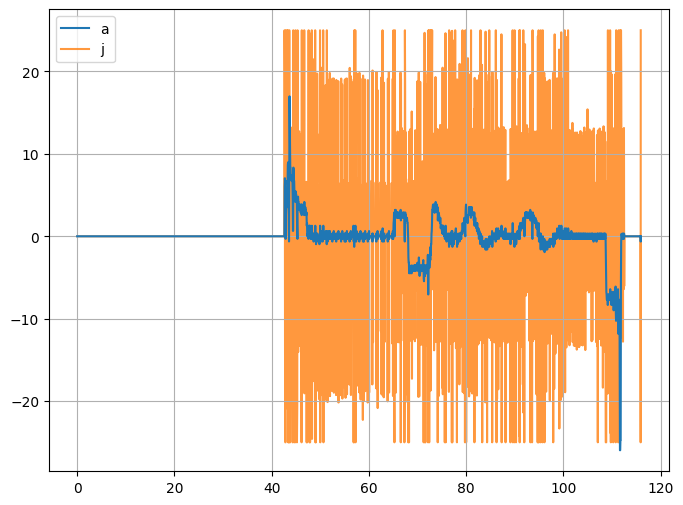

In [15]:
import numpy as np
import matplotlib.pyplot as plt

t = extract_time(imu)
a = imu["ax"].to_numpy()

# время в секунды, если вдруг не в секундах
t = t - t[0]

# численное дифференцирование
dt = np.diff(t)
jerk = np.diff(a) / dt

jerk = np.clip(jerk, -25, 25)

# время для джерка (на полшага сдвинуто)
t_jerk = t[:-1] + dt / 2

plt.figure(figsize=(8, 6))
plt.plot(t, a, label="a")
plt.plot(t_jerk, jerk, label="j", alpha=0.8, zorder=0)
plt.legend()
plt.grid()
plt.show()